We have seen that adding more data was sufficient. Let's try that with previous models:

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
%matplotlib inline

def generate_data(data_path, grayscale=False, downscale=None):
    cardboard, glass, metal, paper, plastic, trash = [], [], [], [], [], []
    for root, _, files in os.walk(data_path):
        for file in files:
            if ".jpg" in file:

                if grayscale:
                    img = cv2.cvtColor(cv2.imread(os.path.join(root, file)), cv2.COLOR_BGR2GRAY)
                else:
                    img = cv2.cvtColor(cv2.imread(os.path.join(root, file)), cv2.COLOR_BGR2RGB)
                
                if downscale:
                    new_size = (int(img.shape[1]/downscale), int(img.shape[0]/downscale))
                    img = cv2.resize(img, new_size)

                if "cardboard" in file: cardboard.append(img)
                elif "glass" in file: glass.append(img)
                elif "metal" in file: metal.append(img)
                elif "paper" in file: paper.append(img)
                elif "plastic" in file: plastic.append(img)
                elif "trash" in file: trash.append(img)
                else: print(f"Unable to classify image: {file}")
    images = {"cardboard": np.array(cardboard), "glass": np.array(glass), "metal": np.array(metal),
              "paper": np.array(paper), "plastic": np.array(plastic), "trash": np.array(trash)}
    return images

labels = {"cardboard": 0, "glass": 1, "metal": 2, "paper": 3, "plastic": 4, "trash": 5}

def label2vec(label):
    vec = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    vec[label] = 1.0
    return np.array(vec)

def train_test_split(images, train_size=0.8, agument=False, vec=False, flatten=False):
    train_data, test_data = [], []
    for key, value in images.items():
        data = value
        random.shuffle(data)
        split_size = int(len(data) * train_size)
        for img in data[:split_size]:
            train_data.append([img, labels[key]])
            if agument:
                train_data.append([cv2.flip(img, 0), labels[key]])
        for img in data[split_size:]:
            test_data.append([img, labels[key]])
            if agument:
                test_data.append([cv2.flip(img, 0), labels[key]])
    
    random.shuffle(train_data)
    random.shuffle(test_data)

    X_train = np.array([(np.ravel(e[0]) if flatten else e[0]) for e in train_data])
    y_train = np.array([(label2vec(e[1]) if vec else e[1]) for e in train_data])

    X_test = np.array([(np.ravel(e[0]) if flatten else e[0]) for e in test_data])
    y_test = np.array([(label2vec(e[1]) if vec else e[1]) for e in test_data])

    return X_train/255, y_train, X_test/255, y_test

In [2]:
images_gray_down4 = generate_data("data", grayscale=True, downscale=4)

X_train, y_train, X_test, y_test = train_test_split(images_gray_down4, train_size=0.9, agument=True, flatten=True)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_Test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (4542, 12288)
y_train: (4542,)
X_Test: (512, 12288)
y_test: (512,)


In [3]:
logistic_regression = LogisticRegression(max_iter=200)
logistic_regression.fit(X_train, y_train)

c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

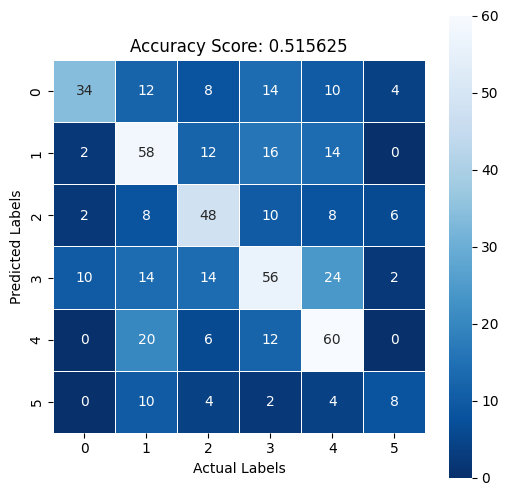

In [4]:
def show_confusion_matrix(confusion_matrix, score):
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrix, annot=True, linewidths=0.5, square=True, cmap="Blues_r")
    plt.xlabel("Actual Labels")
    plt.ylabel("Predicted Labels")
    plt.title(f"Accuracy Score: {score}")

y_pred = logistic_regression.predict(X_test)
score = logistic_regression.score(X_test, y_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

show_confusion_matrix(confusion_matrix, score)

Results are a bit better than the initial Logistic Regression attempt, let's add PCA.

In [5]:
sc = StandardScaler()

accuracies = {}
min_n_components = 100
max_n_components = 125

for n in range(min_n_components, max_n_components+1):
    X_train_pca = sc.fit_transform(X_train)
    X_test_pca = sc.transform(X_test)

    pca = PCA(n_components=n)

    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    logistic_regression_pca = LogisticRegression(max_iter=300)
    logistic_regression_pca.fit(X_train_pca, y_train)

    score_pca = logistic_regression_pca.score(X_test_pca, y_test)

    print(f"n components: {n}/{max_n_components}, accuracy: {score_pca}")

    accuracies[n] = score_pca

n components: 100/125, accuracy: 0.396484375
n components: 101/125, accuracy: 0.37890625
n components: 102/125, accuracy: 0.3828125
n components: 103/125, accuracy: 0.388671875
n components: 104/125, accuracy: 0.390625
n components: 105/125, accuracy: 0.376953125
n components: 106/125, accuracy: 0.39453125
n components: 107/125, accuracy: 0.3828125
n components: 108/125, accuracy: 0.39453125
n components: 109/125, accuracy: 0.390625
n components: 110/125, accuracy: 0.376953125
n components: 111/125, accuracy: 0.390625
n components: 112/125, accuracy: 0.390625
n components: 113/125, accuracy: 0.396484375
n components: 114/125, accuracy: 0.39453125
n components: 115/125, accuracy: 0.396484375
n components: 116/125, accuracy: 0.388671875
n components: 117/125, accuracy: 0.40234375
n components: 118/125, accuracy: 0.40234375
n components: 119/125, accuracy: 0.40234375
n components: 120/125, accuracy: 0.392578125
n components: 121/125, accuracy: 0.39453125
n components: 122/125, accuracy: 0

In [6]:
best_n_components = max(accuracies, key=accuracies.get)

X_train_pca = sc.fit_transform(X_train)
X_test_pca = sc.transform(X_test)

pca = PCA(n_components=best_n_components)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Best n componenets: {best_n_components}")

logistic_regression_pca = LogisticRegression(max_iter=300)
logistic_regression_pca.fit(X_train_pca, y_train)

Best n componenets: 117


LogisticRegression(max_iter=300)

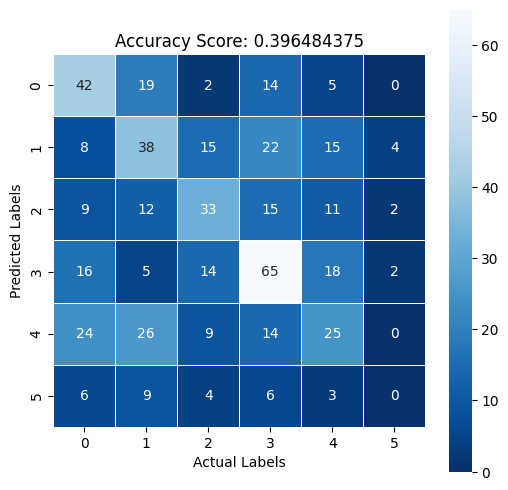

In [7]:
y_pred_pca = logistic_regression_pca.predict(X_test_pca)
score_pca = logistic_regression_pca.score(X_test_pca, y_test)
confusion_matrix_pca = metrics.confusion_matrix(y_test, y_pred_pca)

show_confusion_matrix(confusion_matrix_pca, score_pca)

Seems like Logistic regression is too weak to get above 50% of accuracy.

n components: 1/50, accuracy: 0.69921875
n components: 2/50, accuracy: 0.640625
n components: 3/50, accuracy: 0.59375
n components: 4/50, accuracy: 0.578125
n components: 5/50, accuracy: 0.52734375
n components: 6/50, accuracy: 0.484375
n components: 7/50, accuracy: 0.45703125
n components: 8/50, accuracy: 0.45703125
n components: 9/50, accuracy: 0.4453125
n components: 10/50, accuracy: 0.4296875
n components: 11/50, accuracy: 0.43359375
n components: 12/50, accuracy: 0.41796875
n components: 13/50, accuracy: 0.40234375
n components: 14/50, accuracy: 0.39453125
n components: 15/50, accuracy: 0.40625
n components: 16/50, accuracy: 0.40625
n components: 17/50, accuracy: 0.3984375
n components: 18/50, accuracy: 0.40234375
n components: 19/50, accuracy: 0.3828125
n components: 20/50, accuracy: 0.37109375
n components: 21/50, accuracy: 0.375
n components: 22/50, accuracy: 0.37109375
n components: 23/50, accuracy: 0.36328125
n components: 24/50, accuracy: 0.359375
n components: 25/50, accura

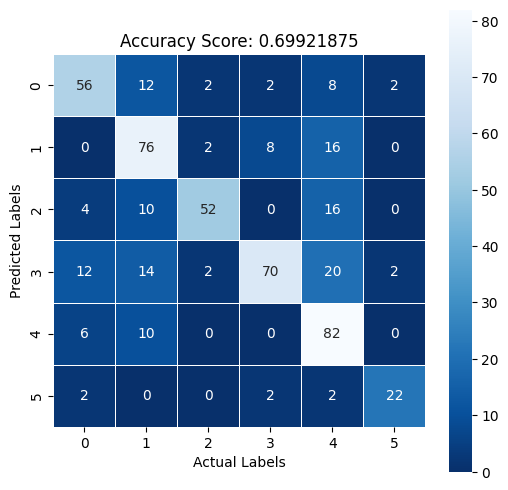

In [8]:
knn_accuracies = {}
max_k_neighbors = 50

for k in range(1, max_k_neighbors+1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    score_knn = knn.score(X_test, y_test)
    knn_accuracies[k] = score

    print(f"n components: {k}/{max_k_neighbors}, accuracy: {score_knn}")

best_k_neighbors = max(knn_accuracies, key=knn_accuracies.get)

knn = KNeighborsClassifier(n_neighbors=best_k_neighbors)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
score_knn = knn.score(X_test, y_test)
confusion_matrix_knn = metrics.confusion_matrix(y_test, y_pred_knn)

show_confusion_matrix(confusion_matrix_knn, score_knn)

n components: 1/50, accuracy: 0.6171875
n components: 2/50, accuracy: 0.638671875
n components: 3/50, accuracy: 0.6953125
n components: 4/50, accuracy: 0.68359375
n components: 5/50, accuracy: 0.67578125
n components: 6/50, accuracy: 0.7421875
n components: 7/50, accuracy: 0.7265625
n components: 8/50, accuracy: 0.74609375
n components: 9/50, accuracy: 0.74609375
n components: 10/50, accuracy: 0.73828125
n components: 11/50, accuracy: 0.73046875
n components: 12/50, accuracy: 0.73828125
n components: 13/50, accuracy: 0.73046875
n components: 14/50, accuracy: 0.7421875
n components: 15/50, accuracy: 0.75
n components: 16/50, accuracy: 0.73828125
n components: 17/50, accuracy: 0.75
n components: 18/50, accuracy: 0.75390625
n components: 19/50, accuracy: 0.740234375
n components: 20/50, accuracy: 0.74609375
n components: 21/50, accuracy: 0.74609375
n components: 22/50, accuracy: 0.755859375
n components: 23/50, accuracy: 0.74609375
n components: 24/50, accuracy: 0.75
n components: 25/50, 

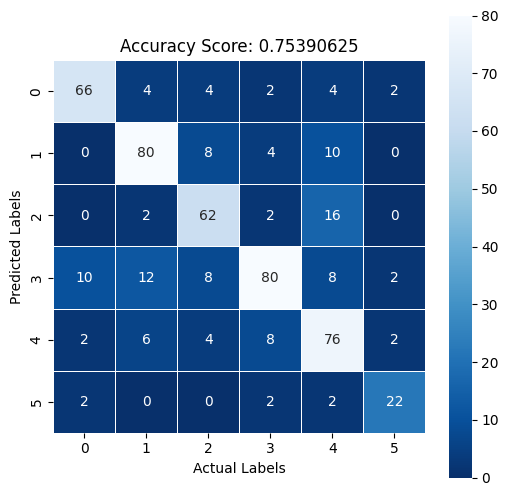

In [9]:
knn_pca_accuracies = {}
max_n_components = 50

for n in range(1, max_n_components+1):
    X_train_pca = sc.fit_transform(X_train)
    X_test_pca = sc.transform(X_test)

    pca = PCA(n_components=n)

    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    knn_pca = KNeighborsClassifier(n_neighbors=best_k_neighbors)
    knn_pca.fit(X_train_pca, y_train)

    score_knn_pca = knn_pca.score(X_test_pca, y_test)

    print(f"n components: {n}/{max_n_components}, accuracy: {score_knn_pca}")

    knn_pca_accuracies[n] = score_knn_pca

best_n_components_knn = max(knn_pca_accuracies, key=knn_pca_accuracies.get)

X_train_pca = sc.fit_transform(X_train)
X_test_pca = sc.transform(X_test)

pca = PCA(n_components=best_n_components_knn)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Best n componenets: {best_n_components_knn}")

knn_pca = KNeighborsClassifier(n_neighbors=best_k_neighbors)
knn_pca.fit(X_train_pca, y_train)

y_pred_knn_pca = knn_pca.predict(X_test_pca)
score_knn_pca = knn_pca.score(X_test_pca, y_test)
confusion_matrix_knn_pca = metrics.confusion_matrix(y_test, y_pred_knn_pca)

show_confusion_matrix(confusion_matrix_knn_pca, score_knn_pca)

Accuracy of 75% using 1 nearest neighbor and 10 components.

When the optimal value of k turns out to be 1, it implies that the data points in the dataset are very closely located and the decision boundary between classes is highly irregular. This means that a query point is likely to have a label that is the same as its closest neighbor in the feature space.

However, selecting k=1 may also lead to overfitting, especially if the dataset has noise or outliers.

In [10]:
svc = svm.SVC(gamma=0.002, C=100)
svc.fit(X_train, y_train)

SVC(C=100, gamma=0.002)

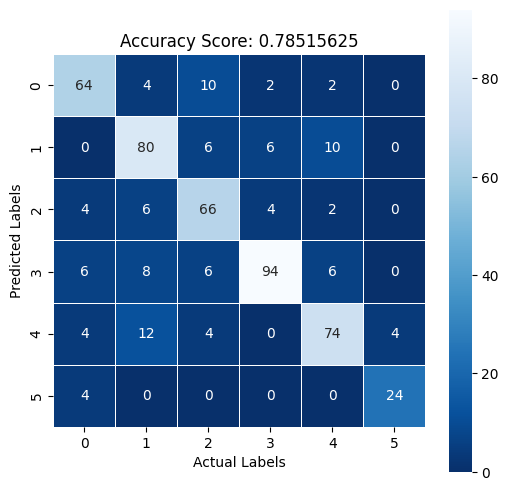

In [11]:
y_pred_svc = svc.predict(X_test)
score_svc = svc.score(X_test, y_test)
confusion_matrix_svc = metrics.confusion_matrix(y_test, y_pred_svc)

show_confusion_matrix(confusion_matrix_svc, score_svc)

In [16]:
sc = StandardScaler()

accuracies = {}
min_n_components = 75
max_n_components = 125

for n in range(min_n_components, max_n_components+1):
    X_train_pca = sc.fit_transform(X_train)
    X_test_pca = sc.transform(X_test)

    pca = PCA(n_components=n)

    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    svc_pca = svm.SVC(gamma=0.002, C=100)
    svc_pca.fit(X_train_pca, y_train)

    score_pca = svc_pca.score(X_test_pca, y_test)

    print(f"n components: {n}/{max_n_components}, accuracy: {score_pca}")

    accuracies[n] = score_pca

n components: 75/125, accuracy: 0.759765625
n components: 76/125, accuracy: 0.7578125
n components: 77/125, accuracy: 0.75
n components: 78/125, accuracy: 0.7578125
n components: 79/125, accuracy: 0.751953125
n components: 80/125, accuracy: 0.751953125
n components: 81/125, accuracy: 0.759765625
n components: 82/125, accuracy: 0.755859375
n components: 83/125, accuracy: 0.755859375
n components: 84/125, accuracy: 0.7578125
n components: 85/125, accuracy: 0.7578125
n components: 86/125, accuracy: 0.748046875
n components: 87/125, accuracy: 0.75
n components: 88/125, accuracy: 0.76171875
n components: 89/125, accuracy: 0.759765625
n components: 90/125, accuracy: 0.7578125
n components: 91/125, accuracy: 0.75
n components: 92/125, accuracy: 0.755859375
n components: 93/125, accuracy: 0.7578125
n components: 94/125, accuracy: 0.755859375
n components: 95/125, accuracy: 0.755859375
n components: 96/125, accuracy: 0.7578125
n components: 97/125, accuracy: 0.755859375
n components: 98/125, ac

Best n componenets: 117


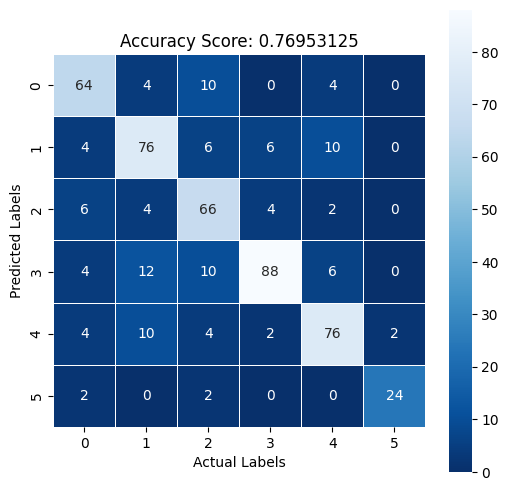

In [17]:
best_n_components = max(accuracies, key=accuracies.get)

X_train_pca = sc.fit_transform(X_train)
X_test_pca = sc.transform(X_test)

pca = PCA(n_components=best_n_components)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Best n componenets: {best_n_components}")

svc_pca = svm.SVC(gamma=0.002, C=100)
svc_pca.fit(X_train_pca, y_train)

y_pred_pca = svc_pca.predict(X_test_pca)
score_pca = svc_pca.score(X_test_pca, y_test)
confusion_matrix_pca = metrics.confusion_matrix(y_test, y_pred_pca)

show_confusion_matrix(confusion_matrix_pca, score_pca)

Conclusions:

agumenting the data was proven effective, achieving much higher accuracies on the weaker models. However, there is a risk of overfitting.